In [2]:
import librosa
import numpy as np

In [3]:
def load_wav_16k(filename):
    wav, sr = librosa.load(filename, sr=16000, mono=True)
    return wav

In [3]:
wave = load_wav_16k("../DroneAudioDataset/Binary_Drone_Audio/yes_drone/B_S2_D1_067-bebop_000_.wav")

In [4]:
import matplotlib.pyplot as plt
import os

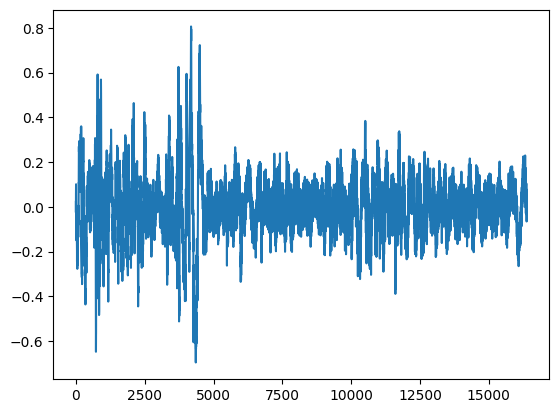

In [5]:
plt.plot(wave)

In [5]:
drone_dataset_dir="../DroneAudioDataset/Binary_Drone_Audio/yes_drone"
unknown_dataset_dir="../DroneAudioDataset/Binary_Drone_Audio/unknown"

In [8]:
drone_durations=[]
unknown_durations=[]
for file in os.listdir(drone_dataset_dir):
    if file.endswith(".wav"):
        drone_file_path = os.path.join(drone_dataset_dir, file)
        drone_wav, sr = librosa.load(drone_file_path, sr=16000, mono=True)
        drone_duration = librosa.get_duration(y=drone_wav, sr=sr)
        drone_durations.append(drone_duration)
for file in os.listdir(unknown_dataset_dir):
    if file.endswith(".wav"):
        unk_file_path = os.path.join(unknown_dataset_dir, file)
        unk_wav, sr = librosa.load(unk_file_path, sr=16000, mono=True)
        unknown_duration = librosa.get_duration(y=unk_wav, sr=sr)
        unknown_durations.append(unknown_duration)
        
drone_durations= np.array(drone_durations)
unknown_durations= np.array(unknown_durations)

print(f"Drone Total files: {len(drone_durations)}")
print(f"Drone Min duration: {drone_durations.min():.2f} sec")
print(f"Drone Max duration: {drone_durations.max():.2f} sec")
print(f"Drone Mean duration: {drone_durations.mean():.2f} sec")

print(f"Unknown Total files: {len(unknown_durations)}")
print(f"Unknown Min duration: {unknown_durations.min():.2f} sec")
print(f"Unknown Max duration: {unknown_durations.max():.2f} sec")
print(f"Unknown Mean duration: {unknown_durations.mean():.2f} sec")

Drone Total files: 1332
Drone Min duration: 0.65 sec
Drone Max duration: 1.02 sec
Drone Mean duration: 1.00 sec
Unknown Total files: 10372
Unknown Min duration: 0.00 sec
Unknown Max duration: 5.12 sec
Unknown Mean duration: 1.03 sec


In [9]:
desired_duration = 1.0
    

In [14]:
drone_audio_dataset = []
unknown_audio_dataset = []
SAMPLE_RATE = 16000

def padding(wav, desired_duration_sec):
    desired_length = int(SAMPLE_RATE * desired_duration_sec)  # convert to number of samples
    current_length = len(wav)

    if current_length > desired_length:
        wav = wav[:desired_length]
    else:
        padding_zeroes = np.zeros(desired_length - current_length)
        wav = np.concatenate((wav, padding_zeroes))

    return wav
    
for file in os.listdir(drone_dataset_dir):
    if file.endswith(".wav"):
        wav = load_wav_16k(os.path.join(drone_dataset_dir,file))
        wav = padding(wav,desired_duration)
        drone_audio_dataset.append(wav)

drone_audio_dataset=np.array(drone_audio_dataset)

for file in os.listdir(unknown_dataset_dir):
    if file.endswith(".wav"):
        wav = load_wav_16k(os.path.join(unknown_dataset_dir,file))
        wav = padding(wav,desired_duration)
        unknown_audio_dataset.append(wav)

unknown_audio_dataset=np.array(unknown_audio_dataset)

In [15]:
print("Shape:", drone_audio_dataset.shape)  # Should be (num_files, 48000)
print("Shape:", unknown_audio_dataset.shape)

Shape: (1332, 16000)
Shape: (10372, 16000)


In [6]:
import librosa.display

In [7]:
def compute_mel_spectrogram(wav, sample_rate=16000, n_mels=64):
    mel_spect = librosa.feature.melspectrogram(y=wav,sr=sample_rate,n_fft=1024,hop_length=512,n_mels=n_mels)

    #conver to log scale (db)
    mel_spect_db = librosa.power_to_db(mel_spect, ref = np.max)
    return mel_spect_db

In [18]:
drone_spectrogram_dataset=[]
unknown_spectrogram_dataset=[]

for wav in drone_audio_dataset:
    drone_spectrogram_dataset.append(compute_mel_spectrogram(wav))
for wav in unknown_audio_dataset:
    unknown_spectrogram_dataset.append(compute_mel_spectrogram(wav))

drone_spectrogram_dataset = np.array(drone_spectrogram_dataset)
unknown_spectrogram_dataset = np.array(unknown_spectrogram_dataset)

print("Drone Spectrogram dataset shape:", drone_spectrogram_dataset.shape) 
print("Unknown Spectrogram dataset shape:", unknown_spectrogram_dataset.shape) 

Drone Spectrogram dataset shape: (1332, 64, 32)
Unknown Spectrogram dataset shape: (10372, 64, 32)


In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(drone_spectrogram_dataset[1], sr=16000, x_axis='time', y_axis='mel')
plt.title('Drone Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 4))
for i in range(len(unknown_spectrogram_dataset)-10000):
    librosa.display.specshow(unknown_spectrogram_dataset[i], sr=16000, x_axis='time', y_axis='mel')
    plt.title('Unknown Random Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


In [8]:
from sklearn.model_selection import train_test_split

In [58]:
import numpy as np

# Adjust this if you're downsampling the unknown dataset
drone_data = drone_spectrogram_dataset
unknown_data = unknown_spectrogram_dataset[:len(drone_data)]

# Create labels
drone_labels = np.ones(len(drone_data))         # Label 1 for drone
unknown_labels = np.zeros(len(unknown_data))    # Label 0 for unknown

# Combine
X = np.concatenate((drone_data, unknown_data), axis=0)
y = np.concatenate((drone_labels, unknown_labels), axis=0)

# Save arrays
np.save("X_spectrogram.npy", X)
np.save("y_labels.npy", y)

print("✅ Saved X_spectrogram.npy and y_labels.npy")


NameError: name 'drone_spectrogram_dataset' is not defined

In [59]:
X = np.load("X_spectrogram.npy")
y = np.load("y_labels.npy")

print("✅ Loaded data shapes:", X.shape, y.shape)


✅ Loaded data shapes: (2664, 64, 32) (2664,)


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Reshape, LSTM, Dense

model = Sequential()

# Convolutional layers
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(64, 32, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Flatten time-frequency into time series for RNN
model.add(Reshape((16, 256)))  # Matches actual tensor size before reshape


# Recurrent layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Output
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/mnt/c/Users/Aayush/Desktop/Projects/SenTRACK/drenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 64, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 32, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 16, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,233 (340.75 KB)

 Trainable params: 87,137 (340.38 KB)

 Non-trainable params: 96 (384.00 B)

In [53]:
X_train = X_train[..., np.newaxis]  # shape: (2131, 64, 32, 1)
X_test = X_test[..., np.newaxis]


In [66]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7980 - loss: 0.4322 - val_accuracy: 0.5197 - val_loss: 1.7736
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9028 - loss: 0.2368 - val_accuracy: 0.9081 - val_loss: 0.2373
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8973 - loss: 0.2382 - val_accuracy: 0.8368 - val_loss: 0.3288
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9134 - loss: 0.1978 - val_accuracy: 0.9193 - val_loss: 0.2142
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9278 - loss: 0.1660 - val_accuracy: 0.8912 - val_loss: 0.2368
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9282 - loss: 0.1612 - val_accuracy: 0.7674 - val_loss: 0.6273
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9305 - loss: 0.1508 - val_accuracy: 0.9400 - val_loss: 0.1859
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9510 - loss: 0.1134 - val_accuracy: 0.9212 - v

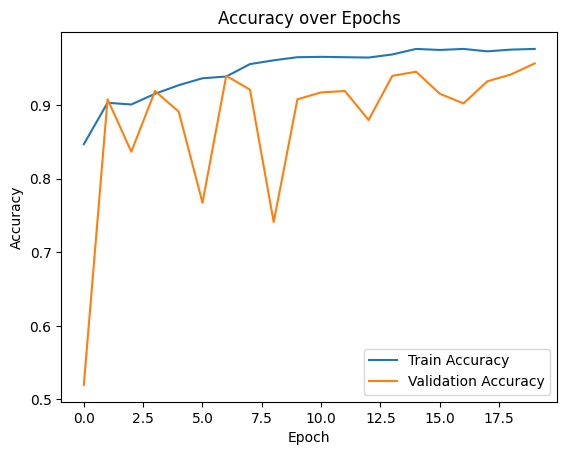

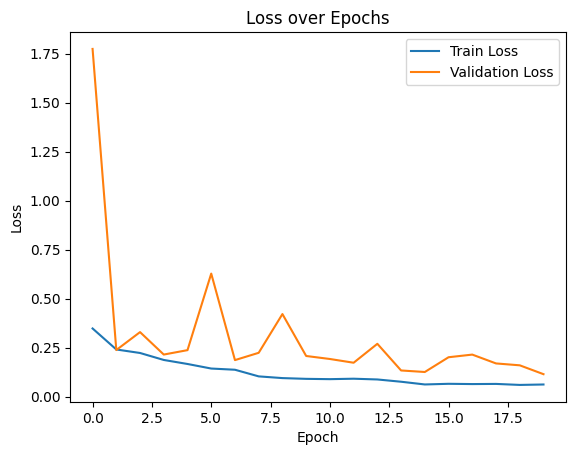

In [67]:
import matplotlib.pyplot as plt

history = model.history

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


In [68]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9546 - loss: 0.1249
Test Accuracy: 0.9568, Test Loss: 0.1142


In [69]:
model.save('crnn_har_model.h5')


In [72]:
print("Keras model input shape:", model.input_shape)
print("Keras model input dtype:", model.inputs[0].dtype)

Keras model input shape: (None, 64, 32, 1)
Keras model input dtype: float32


In [73]:
print("Model built:", model.built)
try:
    print("Model input shape:", model.input_shape)
    print("Model input dtype:", model.inputs[0].dtype)
except Exception as e:
    print("Error getting input info:", e)
    print("Building model using dummy input...")
    dummy_input = np.random.rand(1, 64, 32, 1).astype(np.float32)
    model(dummy_input)
    print("Now input shape:", model.input_shape)
    print("Now input dtype:", model.inputs[0].dtype)


Model built: True
Model input shape: (None, 64, 32, 1)
Model input dtype: float32


In [74]:
import sounddevice as sd
import numpy as np
import librosa
import tensorflow as tf
import time

# Constants
SAMPLE_RATE = 16000  # target sample rate
DURATION = 3  # seconds of audio
CHUNK_SIZE = SAMPLE_RATE * DURATION  # 48000 samples
MODEL_INPUT_SHAPE = (64, 32, 1)  # what your model expects

# Load trained model
model = tf.keras.models.load_model("your_model.h5")

def preprocess_audio(audio):
    # Convert 1D audio to mel-spectrogram of shape (64, 96)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_fft=1024, hop_length=160, n_mels=64)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_db  # shape: (64, ~96)

def segment_and_predict(spectrogram):
    # Segment into overlapping 1-sec chunks (64x32 windows from 64x96)
    segments = []
    for i in range(0, spectrogram.shape[1] - 32 + 1, 16):
        segment = spectrogram[:, i:i+32]
        segments.append(segment)

    segments = np.stack(segments)[..., np.newaxis].astype(np.float32)  # shape: (N, 64, 32, 1)
    preds = model.predict(segments)
    return np.mean(preds)

def stream_and_classify():
    print("Listening...")
    while True:
        audio = sd.rec(frames=CHUNK_SIZE, samplerate=SAMPLE_RATE, channels=1, dtype='float32')
        sd.wait()

        audio = np.squeeze(audio)
        spectrogram = preprocess_audio(audio)

        if spectrogram.shape[1] >= 96:
            spectrogram = spectrogram[:, :96]  # trim or pad if necessary

            pred = segment_and_predict(spectrogram)
            print(f"Prediction (mean): {pred:.4f} — {'DRONE' if pred > 0.5 else 'UNKNOWN'}")
        
        time.sleep(1)  # prevent overlapping reads

# Run it
stream_and_classify()


ModuleNotFoundError: No module named 'sounddevice'